## VCB

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu
data = pd.read_csv('../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (90/10)
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Dự đoán tương lai 30, 60, 90 ngày
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  # Dự đoán 90 ngày
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 0.0215
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 7.5086e-04
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 7.1624e-04
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 6.8219e-04
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 6.3121e-04
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 5.8006e-04
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 5.4124e-04
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 5.0313e-04
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 4.6653e-04
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 4.4101e-04
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 4.2278e-04
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 4.0851e-04
Epoch 13/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 3.9716e-04
Epoch 14/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 3.8788e-04
Epoc

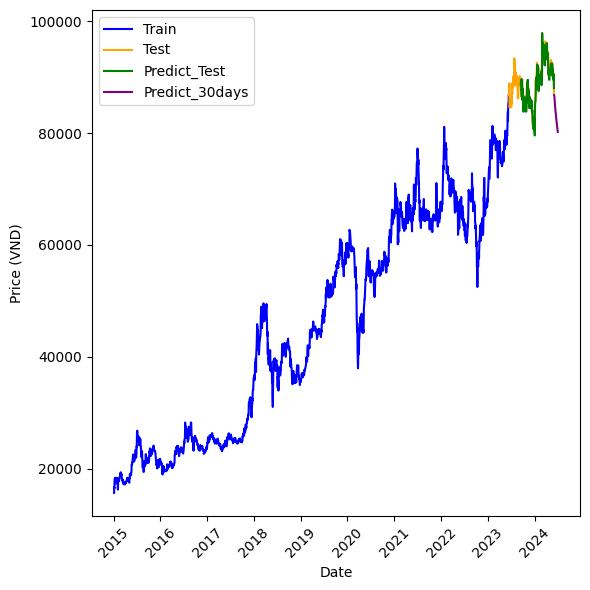

In [2]:
# Trực quan hóa
plt.figure(figsize=(6, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='purple')
# plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='red')
# plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

# plt.title('VCB Stock Price Forecast using LSTM 9:1')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu VCB trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu VCB trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  86796.250000
2024-06-02  86722.015625
2024-06-03  86569.820312
2024-06-04  86268.875000
2024-06-05  85912.242188
...                  ...
2024-08-25  73263.101562
2024-08-26  73177.242188
2024-08-27  73092.281250
2024-08-28  73008.234375
2024-08-29  72925.039062

[90 rows x 1 columns]


In [4]:
# Tính RMSE, MAPE, và MAE trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1171.879428618906
MAPE: 0.9498583599129683 %
MAE: 850.4426185344822


## CTG

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu
data = pd.read_csv('../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (90/10)
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Dự đoán tương lai 30, 60, 90 ngày
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  # Dự đoán 90 ngày
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0278
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0014
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0014
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0013
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0011
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 9.7331e-04
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 8.7777e-04
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 7.9300e-04
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 7.2033e-04
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 6.7223e-04
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 6.4457e-04
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 6.1763e-04
Epoch 13/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 5.8902e-04
Epoch 14/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 5.6185e-04
Epoch 15/100
65/65 ━

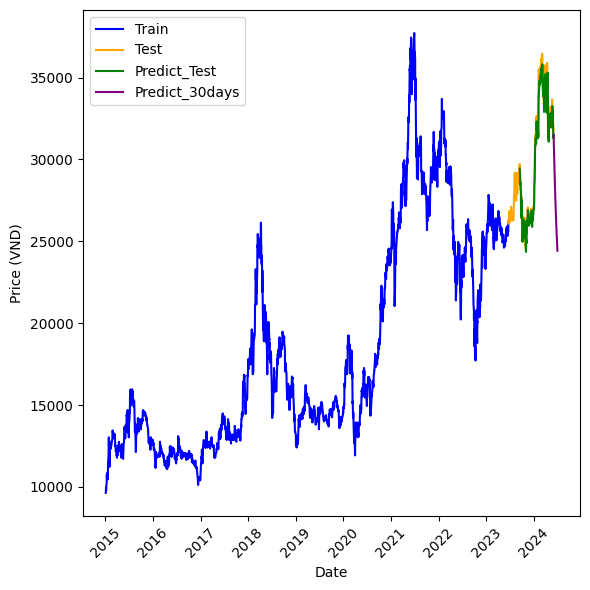

In [6]:
# Trực quan hóa
plt.figure(figsize=(6, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='purple')
# plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='red')
# plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

# plt.title('CTG Stock Price Forecast using LSTM 9:1')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu CTG trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu CTG trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  31520.927734
2024-06-02  31113.990234
2024-06-03  30777.609375
2024-06-04  30487.564453
2024-06-05  30189.431641
...                  ...
2024-08-25  18551.214844
2024-08-26  18479.134766
2024-08-27  18407.771484
2024-08-28  18337.121094
2024-08-29  18267.173828

[90 rows x 1 columns]


In [8]:
# Tính RMSE, MAPE, và MAE trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 659.5487546046924
MAPE: 1.5460502096812396 %
MAE: 482.14619419642855


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu
data = pd.read_csv('../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (90/10)
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Dự đoán tương lai 30, 60, 90 ngày
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  # Dự đoán 90 ngày
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.0209
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 9.8797e-04
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 9.3014e-04
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 8.5251e-04
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 8.1949e-04
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 7.8951e-04
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 7.4181e-04
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 6.9662e-04
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 6.5575e-04
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 6.1865e-04
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 5.8430e-04
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 5.5190e-04
Epoch 13/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 5.2092e-04
Epoch 14/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 4.9119e-04
Epoc

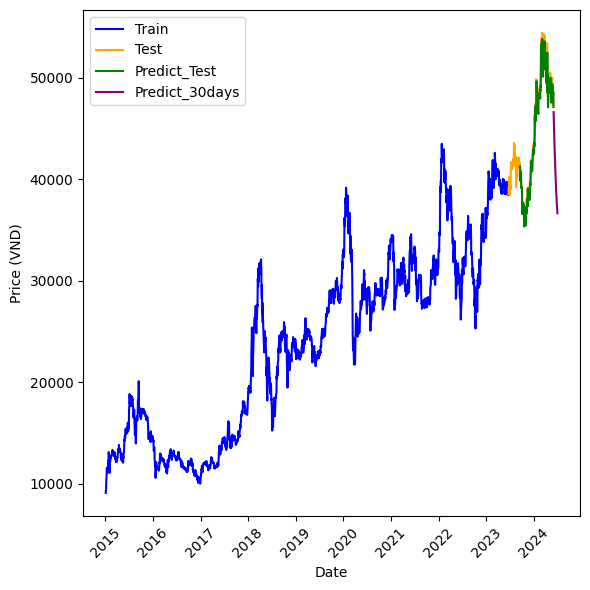

In [10]:
# Trực quan hóa
plt.figure(figsize=(6, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='purple')
# plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='red')
# plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

# plt.title('BID Stock Price Forecast using LSTM 9:1')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu BID trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu BID trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  46604.238281
2024-06-02  46103.992188
2024-06-03  45609.175781
2024-06-04  45122.386719
2024-06-05  44645.417969
...                  ...
2024-08-25  33225.960938
2024-08-26  33215.027344
2024-08-27  33204.578125
2024-08-28  33194.585938
2024-08-29  33185.039062

[90 rows x 1 columns]


In [12]:
# Tính RMSE, MAPE, và MAE trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 962.7452762109276
MAPE: 1.527737736724327 %
MAE: 702.1532142857142
